# Modelos Tradicionais (Baseline)

In [18]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import timedelta
from pandas import IndexSlice as idx

###### Carregar e preparar o dataset

In [2]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

In [3]:
# Filtrar CP 2840 e ordenar
df_cp = df[df["ZipCode"] == "2840"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Colocar o item_id obrigatório para o AutoGluon
df_cp["item_id"] = "2840"
df_cp.set_index("DateTime", inplace=True)

###### Separar treino e teste (até 29-09) e teste (30-09)

In [13]:
treino = df_cp.loc[:'2023-09-29 23:00'].copy() # Treino até 29-09-2023 23:00
teste = df_cp.loc['2023-09-30 00:00':'2023-09-30 23:00'].copy() # Teste apenas para validação visual

treino_reset = treino.reset_index() # Reset index para usar com AutoGluon

###### Criar TimeSeriesDataFrame

In [16]:
train_data = TimeSeriesDataFrame.from_data_frame(
    treino_reset[["item_id", "DateTime", "EnergyNormalized"]],
    id_column="item_id",
    timestamp_column="DateTime"
)

# 📊ARIMA

###### importar modelo

In [ ]:
model_path = "AutogluonModels/ag-20250417_182601" # Caminho onde o modelo foi guardado

predictor = TimeSeriesPredictor.load(model_path) # Carregar o modelo

###### treinar

In [47]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    target="EnergyNormalized",
    eval_metric="MASE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    hyperparameters={"ARIMA": {}},  # apenas ARIMA
    time_limit=300
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250417_185656'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.20 GB / 15.93 GB (26.3%)
Disk Space Avail:   717.29 GB / 931.46 GB (77.0%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'ARIMA': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'EnergyNormalized',
 'time_limit': 300,
 'verbosity': 2}

Inferred time series frequency: 'h'

###### prever

In [48]:
forecast = predictor.predict(train_data)
forecast_values = forecast.loc["2840"]

# Lidar com possíveis múltiplas colunas
if isinstance(forecast_values, pd.DataFrame):
    y_pred = forecast_values.iloc[:, 0].values
else:
    y_pred = forecast_values.values

Model not specified in predict, will default to the model with the best validation score: ARIMA


###### Preparar dados reais

In [49]:
real_values = teste["EnergyNormalized"]
y_true = real_values.values

###### grafico

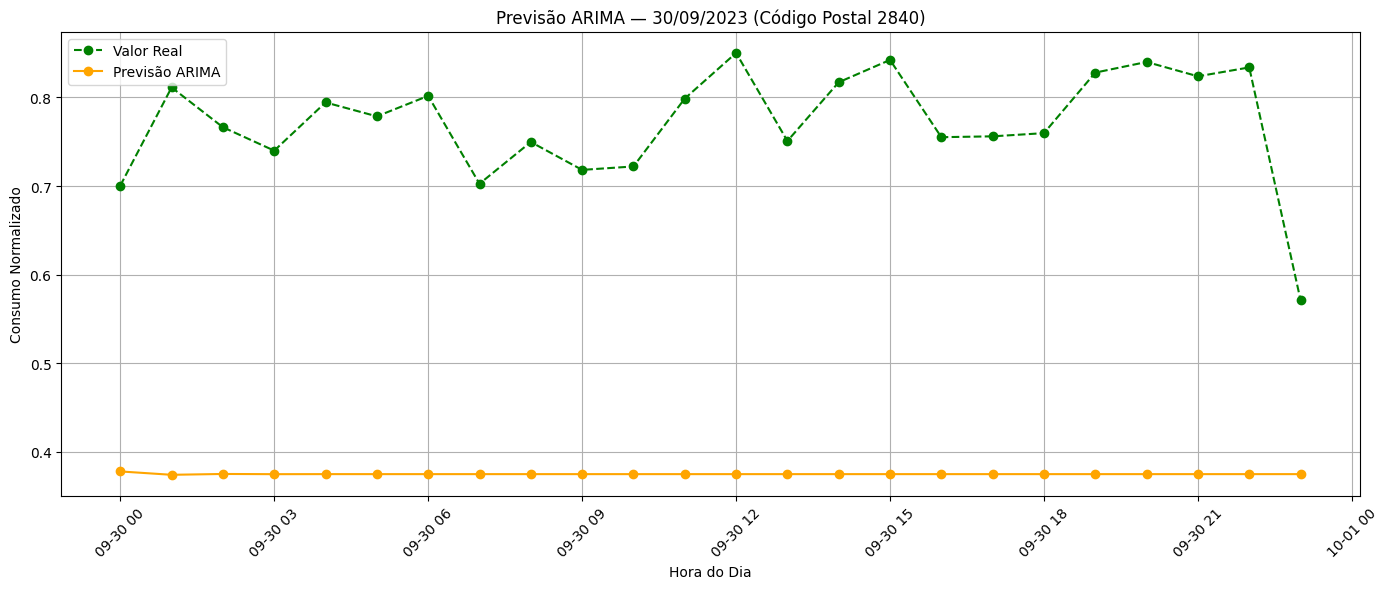

In [50]:
plt.figure(figsize=(14, 6))

plt.plot(real_values.index, real_values.values, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(forecast_values.index, forecast_values.iloc[:, 0] if isinstance(forecast_values, pd.DataFrame) else forecast_values,
         label="Previsão ARIMA", marker='o', color='orange')

plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 2840)")
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

### 🧠 Interpretação geral
ARIMA não é suficiente para este tipo de série com: <br/>
    - Padrões horários<br/>
    - Picos de consumo previsíveis<br/>
    - Influência de variáveis exógenas (ex: temperatura, dia da semana)

In [51]:
# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 MAE: 0.3965
📊 MSE: 0.1609
📊 RMSE: 0.4012
📊 MAPE: 51.05%


### 📊 **Métricas de Avaliação**

| Métrica                                    | Valor  | Interpretação                                                                                                                                                                                                            |
|--------------------------------------------|--------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.3965 | Em média, o erro absoluto foi de ~0.396 unidades normalizadas.                                                                                                 |
| **MSE** (Erro Quadrático Médio)            | 0.1609 | Erros maiores são penalizados; aqui está relativamente moderado.                                                                                                                      |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.4012 | Raiz do MSE, dá uma ideia intuitiva da variação média do erro.                                                                                                                             |
| **MAPE** (Erro Percentual Absoluto Médio)  | 51.05% | O erro percentual médio é relativamente elevado (acima de 30% já é preocupante).                                                                                           |

# 📊XARIMA com variáveis exógenas

In [137]:
def criar_dados_futuros(df_cp, last_forecast_ts, prediction_length, known_covariates):
    future_timestamps = pd.date_range(
        start=last_forecast_ts + pd.Timedelta(hours=1),
        periods=prediction_length,
        freq="h"
    )
    index = pd.MultiIndex.from_product([["4610"], future_timestamps], names=["item_id", "timestamp"])
    df = pd.DataFrame(index=index)

    df["Hour"] = df.index.get_level_values("timestamp").hour
    df["DayOfTheWeek"] = df.index.get_level_values("timestamp").day_name(locale="pt_PT")
    df["Season"] = "Verão"
    df["IsHoliday"] = 0
    df["tod_Manhã"] = df["Hour"].between(7, 12).astype(int)
    df["tod_Tarde"] = df["Hour"].between(13, 19).astype(int)
    df["tod_Noite"] = (~(df["tod_Manhã"].astype(bool) | df["tod_Tarde"].astype(bool))).astype(int)

    # Lags
    for lag in [1, 24, 168]:
        df[f"lag{lag}"] = df_cp["EnergyNormalized"].iloc[-lag]

    df["Temperature"] = df_cp["Temperature"].mean()

    # Forçar tipos categóricos
    df["DayOfTheWeek"] = df["DayOfTheWeek"].astype("category")
    df["Season"] = df["Season"].astype("category")

    # Criar future_data com target nulo
    future_data_df = df.reset_index().copy()
    future_data_df["EnergyNormalized"] = np.nan
    future_data_df["item_id"] = "4610"

    # Garantir colunas
    for col in known_covariates:
        if col not in future_data_df.columns:
            future_data_df[col] = 0

    future_data = TimeSeriesDataFrame.from_data_frame(
        future_data_df[["item_id", "timestamp", "EnergyNormalized"] + known_covariates],
        id_column="item_id",
        timestamp_column="timestamp"
    )
    df.index = future_data.index
    return future_data, df


In [138]:
# === 1. Carregar e preparar os dados ===
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp.sort_values("DateTime", inplace=True)
df_cp.set_index("DateTime", inplace=True)
df_cp["item_id"] = "4610"

# One-hot encoding
df_cp = pd.get_dummies(df_cp, columns=["TimeOfDay"], prefix="tod")

# Lags
df_cp["lag1"] = df_cp["EnergyNormalized"].shift(1)
df_cp["lag24"] = df_cp["EnergyNormalized"].shift(24)
df_cp["lag168"] = df_cp["EnergyNormalized"].shift(168)
df_cp.dropna(subset=["lag1", "lag24", "lag168"], inplace=True)

# === 2. Divisão treino/validação/teste ===
df_cp_reset = df_cp.reset_index()
n = len(df_cp_reset)
n_train = int(n * 0.7)
n_val = int(n * 0.2)

train_df = df_cp_reset.iloc[:n_train].copy()
val_df = df_cp_reset.iloc[n_train:n_train+n_val].copy()
test_df = df_cp_reset.iloc[n_train+n_val:].copy()

real_values = test_df["EnergyNormalized"].copy()
test_df["EnergyNormalized"] = np.nan

# === 3. Variáveis exógenas ===
tod_columns = [col for col in df_cp.columns if col.startswith("tod_")]
known_covariates = ["Temperature", "Hour", "DayOfTheWeek", "Season", "IsHoliday"] + tod_columns + ["lag1", "lag24", "lag168"]

# === 4. Dados para treino e previsão ===
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df[["item_id", "DateTime", "EnergyNormalized"] + known_covariates],
    id_column="item_id",
    timestamp_column="DateTime"
)

# Definir intervalo futuro com base no treino
last_train_ts = train_data.index.get_level_values("timestamp").max()
future_start_ts = last_train_ts + pd.Timedelta(hours=1)
future_end_ts = future_start_ts + pd.Timedelta(hours=23)

# Criar os próximos 24 timestamps futuros
forecast_timestamps = pd.date_range(
    start=last_train_ts + pd.Timedelta(hours=1),
    periods=predictor.prediction_length,
    freq="h"
)

print("Último timestamp de treino:", last_train_ts)
print("Primeiro timestamp de previsão:", forecast_timestamps[0])
print("AutoGluon - Último timestamp de treino:", last_train_ts)
print("Vai prever de:", last_train_ts + pd.Timedelta(hours=1))
print("Até:", last_train_ts + pd.Timedelta(hours=24))
print("Timestamps esperados pela previsão:", forecast_timestamps)

future_index = pd.date_range(start=future_start_ts, end=future_end_ts, freq="h")
future_index = pd.MultiIndex.from_product([["4610"], future_index], names=["item_id", "timestamp"])
future_covariates = pd.DataFrame(index=future_index)

# Preencher as colunas exógenas
future_covariates["Hour"] = future_covariates.index.get_level_values("timestamp").hour
future_covariates["DayOfTheWeek"] = future_covariates.index.get_level_values("timestamp").day_name(locale="pt_PT")
future_covariates["Season"] = "Verão"  # ou função automática
future_covariates["IsHoliday"] = 0

future_covariates["tod_Manhã"] = future_covariates["Hour"].between(7, 12).astype(int)
future_covariates["tod_Tarde"] = future_covariates["Hour"].between(13, 19).astype(int)
future_covariates["tod_Noite"] = (~(future_covariates["tod_Manhã"].astype(bool) | future_covariates["tod_Tarde"].astype(bool))).astype(int)

# Criar as lag features a partir dos últimos dados disponíveis
last_values = df_cp.sort_index().iloc[-168:]
for lag in [1, 24, 168]:
    future_covariates[f"lag{lag}"] = last_values["EnergyNormalized"].iloc[-lag]

# Temperatura: média ou última conhecida
future_covariates["Temperature"] = df_cp["Temperature"].mean()

# Criar future_data com os mesmos índices
future_data_df = future_covariates.reset_index().copy()
future_data_df["EnergyNormalized"] = np.nan
future_data_df["item_id"] = "4610"

# Garantir que todas as known_covariates existem no DataFrame
for col in known_covariates:
    if col not in future_data_df.columns:
        future_data_df[col] = 0  # ou np.nan, conforme a variável

future_data = TimeSeriesDataFrame.from_data_frame(
    future_data_df[["item_id", "timestamp", "EnergyNormalized"] + known_covariates],
    id_column="item_id",
    timestamp_column="timestamp"
)

Último timestamp de treino: 2023-06-24 20:00:00
Primeiro timestamp de previsão: 2023-06-24 21:00:00
AutoGluon - Último timestamp de treino: 2023-06-24 20:00:00
Vai prever de: 2023-06-24 21:00:00
Até: 2023-06-25 20:00:00
Timestamps esperados pela previsão: DatetimeIndex(['2023-06-24 21:00:00', '2023-06-24 22:00:00',
               '2023-06-24 23:00:00', '2023-06-25 00:00:00',
               '2023-06-25 01:00:00', '2023-06-25 02:00:00',
               '2023-06-25 03:00:00', '2023-06-25 04:00:00',
               '2023-06-25 05:00:00', '2023-06-25 06:00:00',
               '2023-06-25 07:00:00', '2023-06-25 08:00:00',
               '2023-06-25 09:00:00', '2023-06-25 10:00:00',
               '2023-06-25 11:00:00', '2023-06-25 12:00:00',
               '2023-06-25 13:00:00', '2023-06-25 14:00:00',
               '2023-06-25 15:00:00', '2023-06-25 16:00:00',
               '2023-06-25 17:00:00', '2023-06-25 18:00:00',
               '2023-06-25 19:00:00', '2023-06-25 20:00:00'],
           

In [140]:
# === 5. Treinar o modelo ===
predictor = TimeSeriesPredictor(
    prediction_length=24,
    target="EnergyNormalized",
    known_covariates_names=known_covariates,
    eval_metric="MASE"
)
predictor.fit(
    train_data,
    hyperparameters={"ARIMA": {}},
    time_limit=300
)

# === 5.5 Diagnóstico de sincronização dos índices ===
future_data = future_data.sort_index()
future_covariates = future_covariates.sort_index()

print("📏 Tamanho de future_data:", len(future_data.index))
print("📏 Tamanho de future_covariates:", len(future_covariates.index))
print("🔍 Diferença em future_data - future_covariates:")
print(future_data.index.difference(future_covariates.index))
print("🔍 Diferença em future_covariates - future_data:")
print(future_covariates.index.difference(future_data.index))

assert future_data.index.equals(future_covariates.index), "❌ Índices de future_data e future_covariates não são iguais!"
print("✅ Índices sincronizados corretamente!")

# 🧠 Garantir que o índice das known_covariates é igual ao que o AutoGluon quer: usar o índice de future_data
expected_index = future_data.index.copy()
# Reindexar as known_covariates para garantir 100% de match
if not future_covariates.index.equals(expected_index):
    future_covariates = future_covariates.reindex(expected_index)
    # Garantir que não ficaram NaNs após reindexação
    if future_covariates.isnull().any().any():
        print("⚠️ Há NaNs em future_covariates após reindexação. A preencher com forward fill.")
        future_covariates.fillna(method="ffill", inplace=True)

    # Confirmar
    assert future_covariates.index.equals(expected_index), "❌ Ainda não bate certo com o índice esperado!"
    print("✅ Índice ajustado com sucesso!")

print("👉 Índice future_data:")
print(future_data.index)
print("👉 Índice future_covariates:")
print(future_covariates.index)

print("🎯 Tipos nas covariáveis:")
print(future_covariates.dtypes)

print("🎯 Índice de previsão esperado pelo AutoGluon:")
print(predictor.prediction_length)
print(future_data.index)


# Forçar tipo category para as colunas categóricas
future_covariates["DayOfTheWeek"] = future_covariates["DayOfTheWeek"].astype("category")
future_covariates["Season"] = future_covariates["Season"].astype("category")

# Forçar os índices de timestamp para datetime64[ns]
future_covariates.index = pd.MultiIndex.from_arrays(
    [
        future_covariates.index.get_level_values("item_id"),
        pd.to_datetime(future_covariates.index.get_level_values("timestamp"))
    ],
    names=["item_id", "timestamp"]
)

future_data.index = pd.MultiIndex.from_arrays(
    [
        future_data.index.get_level_values("item_id"),
        pd.to_datetime(future_data.index.get_level_values("timestamp"))
    ],
    names=["item_id", "timestamp"]
)

print("Timestamps disponíveis nas covariáveis:", future_covariates.index.get_level_values("timestamp").tolist())

print(type(known_covariates))          # Deve ser <class 'pandas.DataFrame'>
print(type(known_covariates.index))    # Deve ser <class 'pandas.core.indexes.multi.MultiIndex'>


max_covariate_ts = future_covariates.index.get_level_values("timestamp").max()
last_forecast_ts = future_data.index.get_level_values("timestamp").max()

new_future_data, new_future_covariates = criar_dados_futuros(
    df_cp=df_cp,
    last_forecast_ts=last_forecast_ts,
    prediction_length=predictor.prediction_length,
    known_covariates=known_covariates
)
print("Último timestamp em new_future_data:", new_future_data.index[-1])
print("Último timestamp em new_future_covariates:", new_future_covariates.index[-1])

# Força os índices a estarem iguais e ordenados
new_future_covariates = new_future_covariates.loc[new_future_data.index]

print("new_future_data.index:")
print(new_future_data.index)

print("new_future_covariates.index:")
print(new_future_covariates.index)

print("Esperado pelo modelo:")
expected_forecast_index = pd.MultiIndex.from_product(
    [["4610"], pd.date_range(start=last_forecast_ts + pd.Timedelta(hours=1), periods=24, freq="h")],
    names=["item_id", "timestamp"]
)
print(expected_forecast_index)

# Verifica se todos os índices batem certo
print("❓ Índices iguais?", new_future_covariates.index.equals(expected_forecast_index))
print("❌ Timestamps em falta:", expected_forecast_index.difference(new_future_covariates.index))

# === 6. Previsão ===
forecast = predictor.predict(
    data=new_future_data,
    known_covariates=new_future_covariates,
)

# === 7. Avaliação ===
forecast_values = forecast.loc["4610"]
forecast_values.index = real_values.head(24).index

y_true = real_values.head(24).values
y_pred = forecast_values.iloc[:, 0].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

No path specified. Models will be saved in: "AutogluonModels\ag-20250419_210247"
Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250419_210247'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.22 GB / 15.93 GB (26.5%)
Disk Space Avail:   717.15 GB / 931.46 GB (77.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'ARIMA': {}},
 'known_covariates_names': ['Temperature',
                            'Hour',
                            'DayOfTheWeek',
                            'Season',
                            'IsHoliday',
                            'tod_Manhã',
                            'tod_Noite',
                        

📏 Tamanho de future_data: 24
📏 Tamanho de future_covariates: 24
🔍 Diferença em future_data - future_covariates:
MultiIndex([], names=['item_id', 'timestamp'])
🔍 Diferença em future_covariates - future_data:
MultiIndex([], names=['item_id', 'timestamp'])
✅ Índices sincronizados corretamente!
👉 Índice future_data:
MultiIndex([('4610', '2023-06-24 21:00:00'),
            ('4610', '2023-06-24 22:00:00'),
            ('4610', '2023-06-24 23:00:00'),
            ('4610', '2023-06-25 00:00:00'),
            ('4610', '2023-06-25 01:00:00'),
            ('4610', '2023-06-25 02:00:00'),
            ('4610', '2023-06-25 03:00:00'),
            ('4610', '2023-06-25 04:00:00'),
            ('4610', '2023-06-25 05:00:00'),
            ('4610', '2023-06-25 06:00:00'),
            ('4610', '2023-06-25 07:00:00'),
            ('4610', '2023-06-25 08:00:00'),
            ('4610', '2023-06-25 09:00:00'),
            ('4610', '2023-06-25 10:00:00'),
            ('4610', '2023-06-25 11:00:00'),
           

ValueError: known_covariates should include the values for prediction_length=23 many time steps into the future.

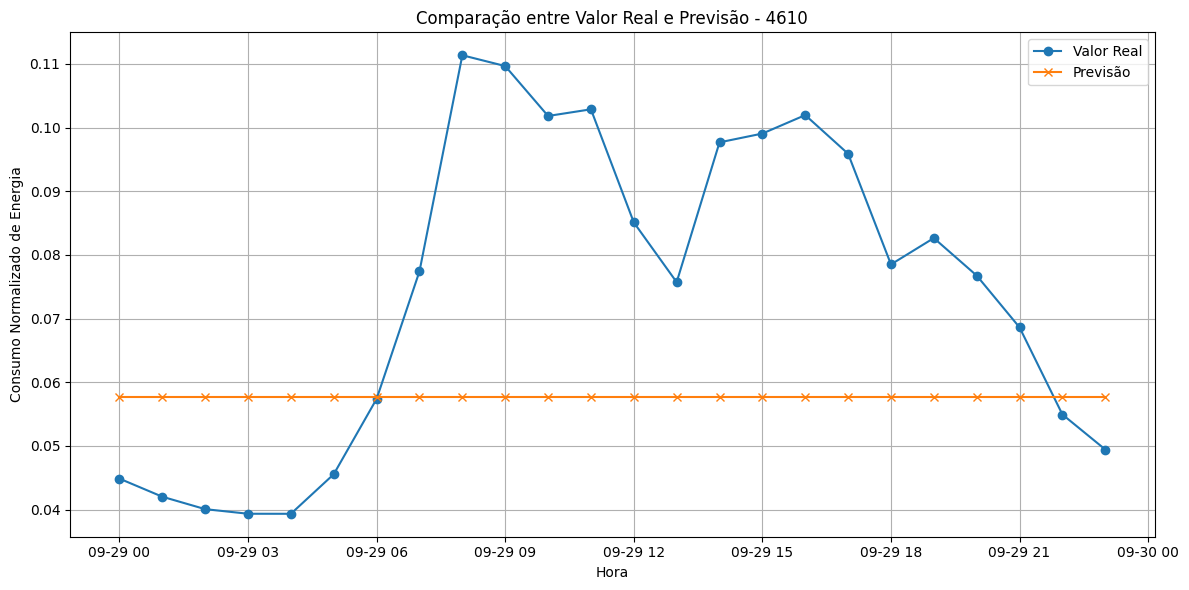

In [43]:
import matplotlib.pyplot as plt

# Criação da figura
plt.figure(figsize=(12, 6))

# Linha dos valores reais
plt.plot(real_values.index, y_true, label="Valor Real", marker='o')

# Linha dos valores previstos
plt.plot(real_values.index, y_pred, label="Previsão", marker='x')

# Título e eixos
plt.title("Comparação entre Valor Real e Previsão - 4610")
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado de Energia")

# Legenda, grelha e layout
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar gráfico
plt.show()